###  Importing Basic Spark Libraries

In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"] = "/opt/cloudera/parcels/Anaconda/bin/python"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/opt/cloudera/parcels/SPARK2-2.3.0.cloudera2-1.cdh5.13.3.p0.316101/lib/spark2/"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.6-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

In [3]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("CTR_prediction_logistic").setMaster("yarn-client")
sc = SparkContext(conf=conf)
sc

<SparkContext master=yarn-client appName=CTR_prediction_logistic>

# EDA

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Logistic_CTR').getOrCreate()

In [5]:
spark

### Load Data

In [6]:
#Upload the dataset in your s3 bucket.
#Moidfy this command according to your s3 bucket.
df = spark.read.csv('s3a://....your s3 bucket name..../ctr_traindata2.csv', header=True, inferSchema=True)

In [7]:
df

DataFrame[id: decimal(20,0), click: int, hour: int, C1: int, banner_pos: int, site_id: string, site_domain: string, site_category: string, app_id: string, app_domain: string, app_category: string, device_id: string, device_ip: string, device_model: string, device_type: int, device_conn_type: int, C14: int, C15: int, C16: int, C17: int, C18: int, C19: int, C20: int, C21: int]

In [8]:
df.show(10)

+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|                  id|click|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
| 1000009418151094273|    0|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| ddd2926e|    44956a24|          1|               2|15706|320| 50|1722|  0| 35|    -1| 79|
|10000169349117863715|    0|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    

In [9]:
df.printSchema()

root
 |-- id: decimal(20,0) (nullable = true)
 |-- click: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_ip: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- C21: integer (nullable = true)



In [10]:
df.columns

['id',
 'click',
 'hour',
 'C1',
 'banner_pos',
 'site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'device_type',
 'device_conn_type',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21']

In [11]:
df.head(5)

[Row(id=Decimal('1000009418151094273'), click=0, hour=14102100, C1=1005, banner_pos=0, site_id=u'1fbe01fe', site_domain=u'f3845767', site_category=u'28905ebd', app_id=u'ecad2386', app_domain=u'7801e8d9', app_category=u'07d7df22', device_id=u'a99f214a', device_ip=u'ddd2926e', device_model=u'44956a24', device_type=1, device_conn_type=2, C14=15706, C15=320, C16=50, C17=1722, C18=0, C19=35, C20=-1, C21=79),
 Row(id=Decimal('10000169349117863715'), click=0, hour=14102100, C1=1005, banner_pos=0, site_id=u'1fbe01fe', site_domain=u'f3845767', site_category=u'28905ebd', app_id=u'ecad2386', app_domain=u'7801e8d9', app_category=u'07d7df22', device_id=u'a99f214a', device_ip=u'96809ac8', device_model=u'711ee120', device_type=1, device_conn_type=0, C14=15704, C15=320, C16=50, C17=1722, C18=0, C19=35, C20=100084, C21=79),
 Row(id=Decimal('10000371904215119486'), click=0, hour=14102100, C1=1005, banner_pos=0, site_id=u'1fbe01fe', site_domain=u'f3845767', site_category=u'28905ebd', app_id=u'ecad2386', 

### Removing Columns which are String & not required

In [12]:
df_selected = df.select(['click', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'])

In [13]:
df_selected.head()

Row(click=0, C1=1005, banner_pos=0, device_type=1, device_conn_type=2, C14=15706, C15=320, C16=50, C17=1722, C18=0, C19=35, C20=-1, C21=79)

In [14]:
df_selected.show(10)

+-----+----+----------+-----------+----------------+-----+---+---+----+---+---+------+---+
|click|  C1|banner_pos|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+-----+----+----------+-----------+----------------+-----+---+---+----+---+---+------+---+
|    0|1005|         0|          1|               2|15706|320| 50|1722|  0| 35|    -1| 79|
|    0|1005|         0|          1|               0|15704|320| 50|1722|  0| 35|100084| 79|
|    0|1005|         0|          1|               0|15704|320| 50|1722|  0| 35|100084| 79|
|    0|1005|         0|          1|               0|15706|320| 50|1722|  0| 35|100084| 79|
|    0|1005|         1|          1|               0|18993|320| 50|2161|  0| 35|    -1|157|
|    0|1005|         0|          1|               0|16920|320| 50|1899|  0|431|100077|117|
|    0|1005|         0|          1|               0|20362|320| 50|2333|  0| 39|    -1|157|
|    0|1005|         1|          1|               0|20632|320| 50|2374|  3| 39|    -1| 23|

In [15]:
df_selected.select("click").distinct().show()

+-----+
|click|
+-----+
|    1|
|    0|
+-----+



In [16]:
df_selected.select("C14").distinct().show()

+-----+
|  C14|
+-----+
|17753|
|20382|
|  463|
|21700|
| 6397|
|20135|
|20596|
| 6393|
|19878|
|12471|
|15538|
| 6559|
| 1270|
|21633|
|21296|
|20170|
| 6361|
|21412|
|21675|
|21484|
+-----+
only showing top 20 rows



In [17]:
df_selected.groupby('click').count().show()

+-----+-----+
|click|count|
+-----+-----+
|    1|17490|
|    0|82509|
+-----+-----+



In [18]:
from pyspark.sql.functions import col, countDistinct

In [19]:
df_selected.agg(countDistinct("click")).show()

+---------------------+
|count(DISTINCT click)|
+---------------------+
|                    2|
+---------------------+



In [20]:
df_selected.agg(countDistinct("C14")).show()

+-------------------+
|count(DISTINCT C14)|
+-------------------+
|                420|
+-------------------+



In [21]:
df_selected.columns

['click',
 'C1',
 'banner_pos',
 'device_type',
 'device_conn_type',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21']

In [22]:
for c in df_selected.columns:
    print c
    

click
C1
banner_pos
device_type
device_conn_type
C14
C15
C16
C17
C18
C19
C20
C21


### Get Distinct Count of Categorical Features

In [23]:
df_selected.agg(*(countDistinct(col(c)).alias(c) for c in df_selected.columns)).show()

+-----+---+----------+-----------+----------------+---+---+---+---+---+---+---+---+
|click| C1|banner_pos|device_type|device_conn_type|C14|C15|C16|C17|C18|C19|C20|C21|
+-----+---+----------+-----------+----------------+---+---+---+---+---+---+---+---+
|    2|  6|         5|          4|               4|420|  5|  6|128|  4| 37|137| 29|
+-----+---+----------+-----------+----------------+---+---+---+---+---+---+---+---+



### Avoid features which are having huge distinct count, Since that many columns will be created while One Hot Encoding

In [24]:
df_filtered = df_selected.select(['click', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18'])

In [25]:
df_filtered.show(10)

+-----+----+----------+-----------+----------------+---+---+---+
|click|  C1|banner_pos|device_type|device_conn_type|C15|C16|C18|
+-----+----+----------+-----------+----------------+---+---+---+
|    0|1005|         0|          1|               2|320| 50|  0|
|    0|1005|         0|          1|               0|320| 50|  0|
|    0|1005|         0|          1|               0|320| 50|  0|
|    0|1005|         0|          1|               0|320| 50|  0|
|    0|1005|         1|          1|               0|320| 50|  0|
|    0|1005|         0|          1|               0|320| 50|  0|
|    0|1005|         0|          1|               0|320| 50|  0|
|    0|1005|         1|          1|               0|320| 50|  3|
|    1|1005|         0|          1|               2|320| 50|  0|
|    0|1002|         0|          0|               0|320| 50|  3|
+-----+----+----------+-----------+----------------+---+---+---+
only showing top 10 rows



In [26]:
df_filtered.agg(*(countDistinct(col(c)).alias(c) for c in df_filtered.columns)).show()

+-----+---+----------+-----------+----------------+---+---+---+
|click| C1|banner_pos|device_type|device_conn_type|C15|C16|C18|
+-----+---+----------+-----------+----------------+---+---+---+
|    2|  6|         5|          4|               4|  5|  6|  4|
+-----+---+----------+-----------+----------------+---+---+---+



In [27]:
df_filtered.printSchema()

root
 |-- click: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C18: integer (nullable = true)



In [28]:
df_filtered.columns

['click',
 'C1',
 'banner_pos',
 'device_type',
 'device_conn_type',
 'C15',
 'C16',
 'C18']

# Data Preparation

### No String, All Integer columns, So String Indexer not required, we can directly go for one-hot encoding

### One hot encoding

In [29]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, OneHotEncoderEstimator

In [30]:
OHE = OneHotEncoderEstimator(inputCols=['C1', 'banner_pos', 'device_type', 'device_conn_type',
                                        'C15', 'C16', 'C18'],outputCols=['C1_encoded', 'banner_pos_encoded', 
                                                                         'device_type_encoded', 
                                                                         'device_conn_type_encoded', 'C15_encoded',
                                                                         'C16_encoded', 'C18_encoded'])

### Vector Assembler

In [31]:
vec_assembler = VectorAssembler(inputCols=['C1_encoded', 'banner_pos_encoded', 
                                           'device_type_encoded', 'device_conn_type_encoded', 
                                           'C15_encoded', 'C16_encoded', 'C18_encoded'], outputCol="features")

### Pipeline

In [32]:
# Make the pipeline
final_pipe = Pipeline(stages=[OHE, vec_assembler])

In [33]:
piped_data = final_pipe.fit(df_filtered).transform(df_filtered)

In [34]:
piped_data.show(10)

+-----+----+----------+-----------+----------------+---+---+---+-------------------+----------------+------------------+-------------+-------------------+------------------------+-----------------+--------------------+
|click|  C1|banner_pos|device_type|device_conn_type|C15|C16|C18|device_type_encoded|     C16_encoded|banner_pos_encoded|  C18_encoded|         C1_encoded|device_conn_type_encoded|      C15_encoded|            features|
+-----+----+----------+-----------+----------------+---+---+---+-------------------+----------------+------------------+-------------+-------------------+------------------------+-----------------+--------------------+
|    0|1005|         0|          1|               2|320| 50|  0|      (5,[1],[1.0])|(480,[50],[1.0])|     (5,[0],[1.0])|(3,[0],[1.0])|(1010,[1005],[1.0])|           (5,[2],[1.0])|(728,[320],[1.0])|(2236,[1005,1010,...|
|    0|1005|         0|          1|               0|320| 50|  0|      (5,[1],[1.0])|(480,[50],[1.0])|     (5,[0],[1.0])|(3,[

In [35]:
piped_data.columns

['click',
 'C1',
 'banner_pos',
 'device_type',
 'device_conn_type',
 'C15',
 'C16',
 'C18',
 'device_type_encoded',
 'C16_encoded',
 'banner_pos_encoded',
 'C18_encoded',
 'C1_encoded',
 'device_conn_type_encoded',
 'C15_encoded',
 'features']

In [36]:
piped_dataset = piped_data.withColumnRenamed("click", "label")

In [37]:
piped_dataset.show(10)

+-----+----+----------+-----------+----------------+---+---+---+-------------------+----------------+------------------+-------------+-------------------+------------------------+-----------------+--------------------+
|label|  C1|banner_pos|device_type|device_conn_type|C15|C16|C18|device_type_encoded|     C16_encoded|banner_pos_encoded|  C18_encoded|         C1_encoded|device_conn_type_encoded|      C15_encoded|            features|
+-----+----+----------+-----------+----------------+---+---+---+-------------------+----------------+------------------+-------------+-------------------+------------------------+-----------------+--------------------+
|    0|1005|         0|          1|               2|320| 50|  0|      (5,[1],[1.0])|(480,[50],[1.0])|     (5,[0],[1.0])|(3,[0],[1.0])|(1010,[1005],[1.0])|           (5,[2],[1.0])|(728,[320],[1.0])|(2236,[1005,1010,...|
|    0|1005|         0|          1|               0|320| 50|  0|      (5,[1],[1.0])|(480,[50],[1.0])|     (5,[0],[1.0])|(3,[

In [38]:
model_data = piped_dataset.select(['label','features'])

In [39]:
model_data.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1011,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1011,...|
|    1|(2236,[1005,1010,...|
|    0|(2236,[1002,1010,...|
+-----+--------------------+
only showing top 10 rows



In [40]:
model_data.head(10)

[Row(label=0, features=SparseVector(2236, {1005: 1.0, 1010: 1.0, 1016: 1.0, 1022: 1.0, 1345: 1.0, 1803: 1.0, 2233: 1.0})),
 Row(label=0, features=SparseVector(2236, {1005: 1.0, 1010: 1.0, 1016: 1.0, 1020: 1.0, 1345: 1.0, 1803: 1.0, 2233: 1.0})),
 Row(label=0, features=SparseVector(2236, {1005: 1.0, 1010: 1.0, 1016: 1.0, 1020: 1.0, 1345: 1.0, 1803: 1.0, 2233: 1.0})),
 Row(label=0, features=SparseVector(2236, {1005: 1.0, 1010: 1.0, 1016: 1.0, 1020: 1.0, 1345: 1.0, 1803: 1.0, 2233: 1.0})),
 Row(label=0, features=SparseVector(2236, {1005: 1.0, 1011: 1.0, 1016: 1.0, 1020: 1.0, 1345: 1.0, 1803: 1.0, 2233: 1.0})),
 Row(label=0, features=SparseVector(2236, {1005: 1.0, 1010: 1.0, 1016: 1.0, 1020: 1.0, 1345: 1.0, 1803: 1.0, 2233: 1.0})),
 Row(label=0, features=SparseVector(2236, {1005: 1.0, 1010: 1.0, 1016: 1.0, 1020: 1.0, 1345: 1.0, 1803: 1.0, 2233: 1.0})),
 Row(label=0, features=SparseVector(2236, {1005: 1.0, 1011: 1.0, 1016: 1.0, 1020: 1.0, 1345: 1.0, 1803: 1.0})),
 Row(label=1, features=Spar

# Model Building

### Create Train Test Data

In [41]:
training, test = model_data.randomSplit([.7, .3])

In [42]:
training.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(2236,[1001,1010,...|
|    0|(2236,[1001,1010,...|
|    0|(2236,[1001,1010,...|
|    0|(2236,[1001,1010,...|
|    0|(2236,[1001,1010,...|
|    0|(2236,[1002,1010,...|
|    0|(2236,[1002,1010,...|
|    0|(2236,[1002,1010,...|
|    0|(2236,[1002,1010,...|
|    0|(2236,[1002,1010,...|
+-----+--------------------+
only showing top 10 rows



In [43]:
training.count()

69586

### Logistic Regression Model

In [44]:
from pyspark.ml.classification import LogisticRegression

In [45]:
lr = LogisticRegression(featuresCol='features', labelCol='label')

In [46]:
lr

LogisticRegression_485e80c5c39cdaaa390b

In [47]:
model = lr.fit(training)

In [48]:
model

LogisticRegression_485e80c5c39cdaaa390b

# Model Evaluation

In [49]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

Coefficients: (2236,[1001,1002,1005,1007,1008,1010,1011,1012,1014,1015,1016,1019,1020,1022,1023,1145,1241,1325,1345,1773,1789,1803,1843,2003,2233,2234,2235],[0.7681884286025666,0.35007885502772523,0.4891791426935245,-35.06164770481844,1.859148042611447,-0.5461800073170227,-0.3088341483830885,-0.5173977263011516,0.610166548299617,0.35007885502772523,-0.026110657509767408,-0.46601262956046396,1.560304409522836,1.47703543139025,1.3024447103106152,-16.57815741127143,-0.755873426468991,-1.2451249452998048,-1.5396469788325895,-16.57815741127143,-0.755873426468991,-0.15190983069580183,-37.39412692744017,0.3459677651880881,0.15732562770669728,-0.7854744473017999,1.0499442326293027])
Intercept: -1.68987940323


### Plot ROC

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline


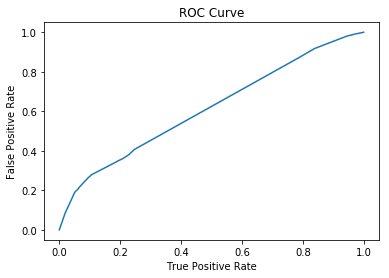

In [54]:

trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


In [55]:
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Training set areaUnderROC: 0.612536188569


### Precision Recall Curve

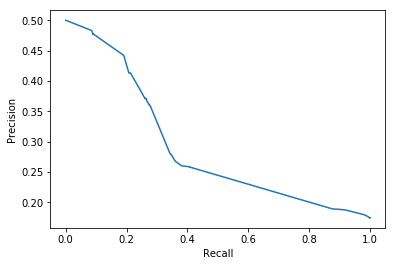

In [58]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Accuracy 

In [59]:
summary = model.evaluate(test)

In [60]:
summary.accuracy

0.8239239798770263

In [61]:
output = model.transform(test)

In [62]:
output

DataFrame[label: int, features: vector, rawPrediction: vector, probability: vector, prediction: double]

### Probability Output

In [63]:
output.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(2236,[1001,1010,...|[1.62523403946446...|[0.83551570348846...|       0.0|
|    0|(2236,[1001,1010,...|[1.62523403946446...|[0.83551570348846...|       0.0|
|    0|(2236,[1001,1010,...|[1.70850301759705...|[0.84664201791488...|       0.0|
|    0|(2236,[1001,1010,...|[1.70850301759705...|[0.84664201791488...|       0.0|
|    0|(2236,[1002,1010,...|[1.48734414391140...|[0.81567930844151...|       0.0|
|    0|(2236,[1002,1010,...|[1.48734414391140...|[0.81567930844151...|       0.0|
|    0|(2236,[1002,1010,...|[1.48734414391140...|[0.81567930844151...|       0.0|
|    0|(2236,[1002,1010,...|[1.48734414391140...|[0.81567930844151...|       0.0|
|    0|(2236,[1002,1010,...|[1.48734414391140...|[0.81567930844151...|       0.0|
|    0|(2236,[10

In [64]:
output.select('label','prediction').show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 10 rows



### ROC

In [65]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [66]:
evaluator = BinaryClassificationEvaluator()

In [67]:
print('Test Area Under ROC', evaluator.evaluate(output))

('Test Area Under ROC', 0.600013824471185)
